### Floating-point sowing and rewards v1.6

The environment now largely conforms to the OpenAI env style, with the env written as a class having a standard set of methods (step, reset, render, close).  AFAICT, making this into a proper OpenAI env means setting up a special directory structure such that it can be loaded and run with the `gym.make()` function---but that isn't nearly as readable as a notebook like this.  The following three cells have the environment and agent code.  

The original (oldest) agent is very dumb; it merely samples from the space of possible action-weight distributions and sows according to the sampled distribution.  Iteration allows it to keep the best distribution it has discovered.  

The newer agent (just below the env code) is slightly smarter.  It takes a biased random walk through weight space, committing to only those steps which produce an increased yield at the end of an episode.  (You can see that, at the moment, it tends toward favoring squash, which in the current reward function provides the highest single-plant reward.)

To-do list for the **environment**:

* try out official OpenAI file + directory structure
* determine the correct gym `space` for the observation space (an *n* x 3 array where the value of *n* isn't fixed until the end of the episode)
* treat plants as enumeration class (maybe? need to make sure attributes like age still available)
* elaborate reward functions and make them more biologically plausible
* * in particular, write something extremely plausible for maize-only planting? (for our beyond-the-row paper)
* update the `render()` code:
* * have one output option be a series of 6 snapshots illustrating an agent's learning
* * another output option for a movie


To-do list for the **agent**:

* write a variety of learning algorithms (to have a bake-off) and wrap them in functions.  most obviously this would include RL algorithms, but shouldn't overlook e.g. quality diversity
* * look at what sklearn has to offer
* currently the only thing the agent can observe is the .field property, which is the location and species of each plant.  add a separate .state property of the environment with additional features to observe?  for example, the ages of each plant


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from enum import Enum

class Plant:
    def __init__(self, species, maturity=110):
        self.species = species
        self.maturity = maturity
        self.age = 0
        
    def __repr__(self):
        return "{}".format(self.species)
    

class Field(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, size=5, sow_limit=200, season=120, calendar=0):
        # parameters for overall field character
        self.size = size
        self.sow_limit = sow_limit
        self.season = season
        self.calendar = calendar
        
        # constants for computing end-of-season reward---distances represent meters
        self.crowding_dist = .02
        self.maize_maize_dist = .1
        self.bean_support_dist = .1
        self.crowding_penalty = .1
        self.maize_maize_penalty = .9
        self.bean_support_bonus = .6
        
        # OpenAI action and observation space specifications
        self.action_space = spaces.Discrete(4)
        # self.observation_space = spaces.???
        
        # field is initialized by calling reset()
        self.field = None
        
    def step(self, action):
        # sow plants (or wait) depending on actions chosen
        # action is an array of n choices; value of n specified in agent code sow_limit
        # could be cleaned up with plants as an enumeration?
        
        for choice in action:
            if choice == 0:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Maize')]], axis=0)
            elif choice == 1:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Bean')]], axis=0)
            elif choice == 2:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Squash')]], axis=0)
            # when choice == 3, nothing is done (agent waits)   
            
        
        # increment timekeeping
        self.calendar +=1
        for plant in self.field:
            plant[2].age += 1
            
        done = self.calendar == self.season
            
        if not done:
            reward = 0
        else:
            reward = self.get_reward()
            
        return self.field, reward, done, {}
    
    def reset(self):
        # field is initialized with one random corn plant in order to make sowing (by np.append) work
        self.field = np.array([[self.size * np.random.random(), 
                                self.size * np.random.random(), 
                                Plant('Maize')]])
        # timekeeping is reset
        self.calendar = 0
        
    def render(self, mode='human'):
        # initialize plant type arrays so that pyplot won't break if any is empty
        maize = np.array([[None, None]])
        bean = np.array([[None, None]])
        squash = np.array([[None, None]])
        maize_imm = np.array([[None, None]])
        bean_imm = np.array([[None, None]])
        squash_imm = np.array([[None, None]])
        
        # replace initial arrays with coordinates for each plant type
        maize = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age >= row[2].maturity])
        bean = np.array([row for row in self.field 
                            if row[2].__repr__() == 'Bean' and row[2].age >= row[2].maturity])
        squash = np.array([row for row in self.field 
                              if row[2].__repr__() == 'Squash' and row[2].age >= row[2].maturity])
        maize_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age < row[2].maturity])
        bean_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Bean' and row[2].age < row[2].maturity])
        squash_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Squash' and row[2].age < row[2].maturity])
        
        # plot the field---currently breaks if any plant type is absent
        plt.figure(figsize=(10, 10))
        plt.scatter(maize[:,0], maize[:,1], c='green', s=200, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(bean[:,0], bean[:,1], c='brown', s=150, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(squash[:,0], squash[:,1], c='orange', s=400, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(maize_imm[:,0], maize_imm[:,1], c='green', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(bean_imm[:,0], bean_imm[:,1], c='brown', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(squash_imm[:,0], squash_imm[:,1], c='orange', s=200, marker = 'o', alpha=.1, edgecolor='#303030')

        plt.show()
        
        print("Total yield in Calories is {}.\n---\n".format(round(reward, 1)))
    
    def close(self):
        # unneeded right now? AFAICT this is only used to shut down realtime movie visualizations
        pass
    
    def get_reward(self):
        # array of plant coordinates for computing distances
        xy_array = np.array([[row[0], row[1]] for row in self.field])

        # distances[m,n] is distance from mth to nth plant in field
        distances = np.linalg.norm(xy_array - xy_array[:,None], axis=-1)
        
        reward = 0
        i = 0
        while i < len(self.field):
            if self.field[i,2].age < self.field[i,2].maturity:
                reward += 0
            elif self.field[i,2].__repr__() == 'Maize':
                cal = 1
                j = 0
                while j < len(distances[0]):
                    if (self.field[j,2].__repr__() == 'Bean' 
                            and distances[i,j] < self.bean_support_dist):
                        cal += self.bean_support_bonus
                    if (self.field[j,2].__repr__() == 'Maize' 
                            and i !=j 
                            and distances[i,j] < self.maize_maize_dist):
                        cal *= self.maize_maize_penalty
                    if 0 < distances[i,j] < self.crowding_dist:
                        cal *= self.crowding_penalty
                    j += 1
                reward += cal
            elif self.field[i,2].__repr__() == 'Bean':
                reward += .25
            elif self.field[i,2].__repr__() == 'Squash':
                reward += 3
            i += 1        
        return reward


Results after 0 trials:


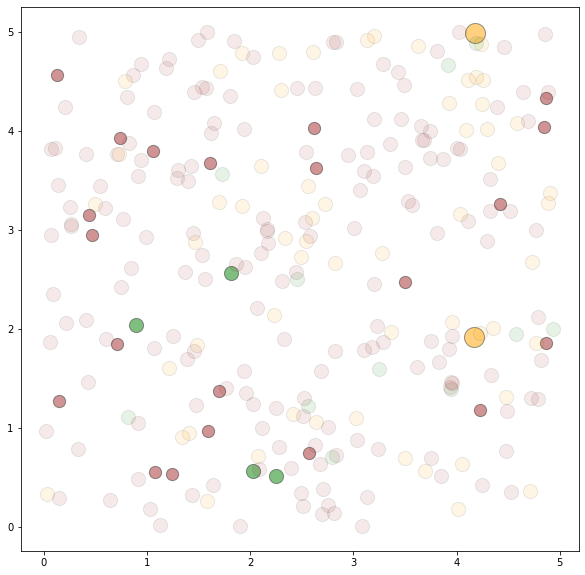

Total yield in Calories is 16.4.
---

Results after 20 trials:


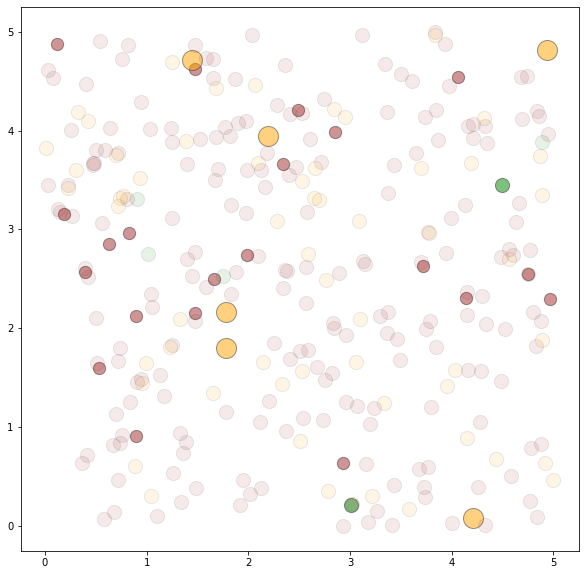

Total yield in Calories is 24.4.
---

Results after 40 trials:


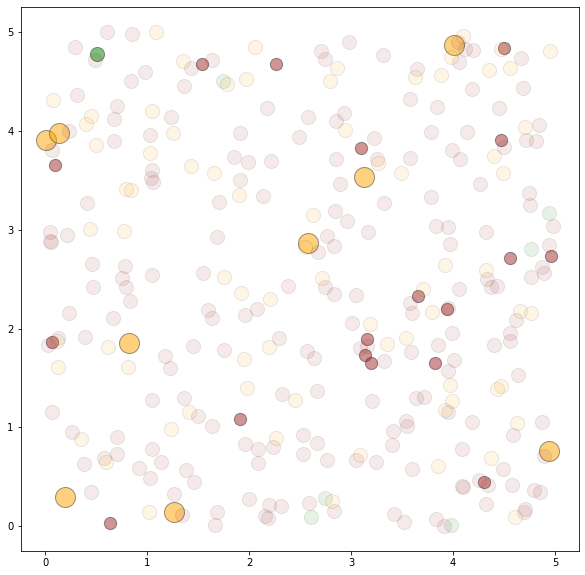

Total yield in Calories is 33.1.
---

Results after 60 trials:


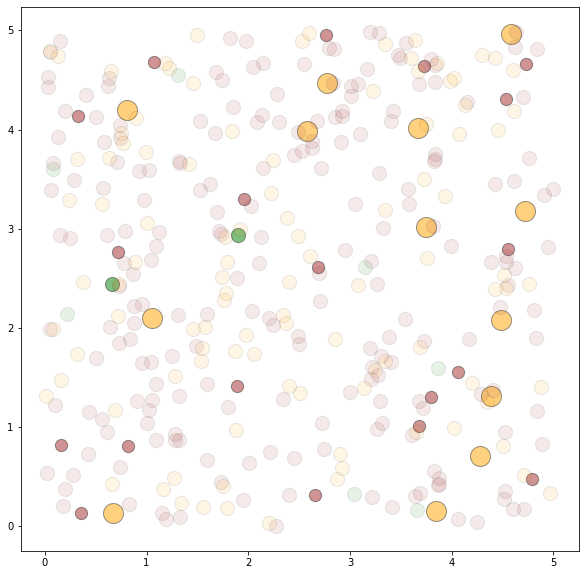

Total yield in Calories is 46.4.
---

Results after 80 trials:


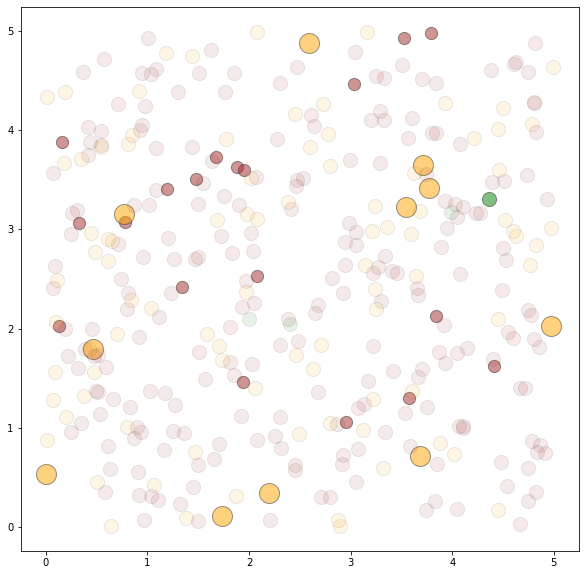

Total yield in Calories is 38.8.
---

Results after 100 trials:
Yield history is:  [16, 18, 21, 22, 10, 23, 26, 20, 29, 16, 21, 27, 32, 29, 23, 19, 17, 40, 15, 35, 24, 24, 26, 19, 25, 24, 34, 30, 32, 30, 29, 32, 18, 41, 32, 22, 29, 40, 26, 20, 33, 33, 34, 35, 25, 41, 46, 33, 48, 41, 31, 52, 31, 38, 32, 31, 32, 24, 44, 36, 46, 41, 42, 31, 39, 46, 26, 40, 26, 31, 53, 36, 31, 44, 36, 53, 28, 37, 36, 40, 39, 43, 48, 33, 28, 44, 40, 46, 40, 34, 35, 34, 37, 31, 45, 41, 37, 31, 26, 26]
Best weights discovered are: 
	sow maize 	0.0023541021938594305 
	sow bean 	0.6599721617912012 
	sow squash 	0.3147763647157801        
	wait 		0.022897371299158725


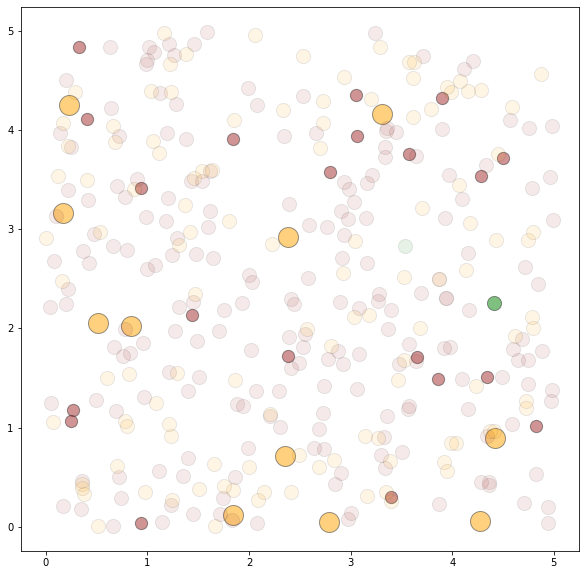

Total yield in Calories is 39.2.
---



In [3]:
# second agent: biased search in weight space

import gym
import numpy as np

# global parameters for trials
testbed = Field()
best_weights = np.random.dirichlet(np.ones(4))
best_yield = 0
yield_history = []
sow_limit = 3
num_trials = 100

# for storing subplots
subplots = []


# does a random walk in weight space and keeps any step that improves yield
for i in range(num_trials):
    
    # initialize trial
    observation = testbed.reset()
#     print("init observation", observation)
    done = False
    count = 0
    
    # calculate step vector for random walk
    epsilon = np.random.random(1) / 20
    delta = epsilon * np.random.permutation([1, 1, -1, -1])
    
    while not done:
        count += 1
        
        # ensure step won't take agent outside of weight space
        while True in ((best_weights + delta) < 0):
            epsilon = np.random.random(1) / 20
            delta = epsilon * np.random.permutation([1, 1, -1, -1])
        weights = best_weights + delta
        action = [np.random.choice(4, p=weights) for i in range(sow_limit)]
#         print("action", action)
        observation, reward, done, _ = testbed.step(action)
        
        if done:
            yield_history.append(round(reward))
            if reward > best_yield:
                best_yield = reward
                best_weights = weights
                
    if i % 20 == 0:
        print("Results after {} trials:".format(i))
        subplot = testbed.render()
        # subplots.append(subplot) # attempting to get a six-in-one figure


# run a final trial using the best weights discovered
observation = testbed.reset()
done = False
while not done:
    weights = best_weights
    action = [np.random.choice(4, p=best_weights) for i in range(sow_limit)]
    observation, reward, done, _ = testbed.step(action)
#     print("observation", observation)
#     print("reward", reward)
#     print("done", done)
    

# show results
print("Results after {} trials:".format(num_trials))
print("Yield history is: ", yield_history)
#print(best_yield)
print("Best weights discovered are: \n\tsow maize \t{} \n\tsow bean \t{} \n\tsow squash \t{} \
       \n\twait \t\t{}".format(best_weights[0], best_weights[1], best_weights[2], best_weights[3]))
            
testbed.render()
#print(subplots)


[0.53871116 0.07190444 0.08216434 0.30722007]


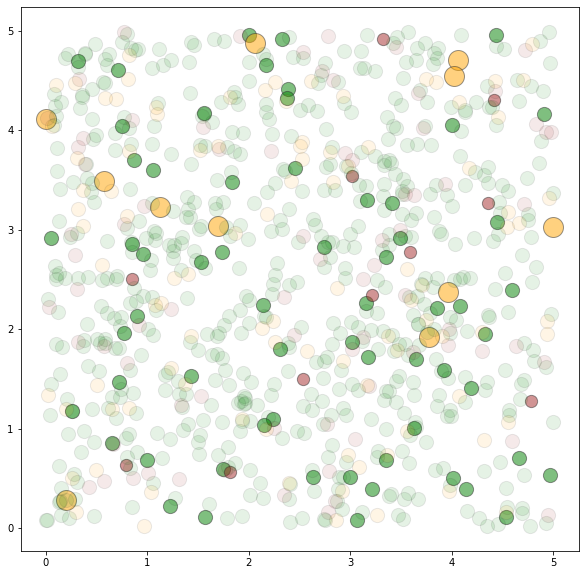

Total yield in Calories is 96.4.
---



In [5]:
# simple agent: takes random sample of weight space to arrive at best weights

import gym
import numpy as np

testbed = Field()
best_weights = np.zeros(4)
best_yield = 0
yield_history = []
sow_limit = 10


# run the trials where each set of weights produces a yield
for i in range(100):
    observation = testbed.reset()
    done = False
    count = 0
    while not done:
        count += 1
        weights = np.random.dirichlet(np.ones(4))
        action = [np.random.choice(4, p=weights) for i in range(sow_limit)]
        observation, reward, done, _ = testbed.step(action)
        
        if done:
            yield_history.append(round(reward))
            if reward > best_yield:
                best_yield = reward
                best_weights = weights


# run a final trial using the best weights discovered
observation = testbed.reset()
done = False
while not done:
    weights = best_weights
    action = [np.random.choice(4, p=best_weights) for i in range(sow_limit)]
    observation, reward, done, _ = testbed.step(action)
    

# show results
#print(yield_history)
#print(best_yield)
print(best_weights)
            
testbed.render()
